In [1]:
import numpy as np
from sif.kernels import SquaredExponentialKernel, MaternKernel
from sif.models import GaussianProcess
from sif.acquisitions import ExpectedImprovement, ImprovementProbability
from sif.samplers import EllipticalSliceSampler

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Create random data.

In [3]:
X = np.random.uniform(size=(100, 1))
y = np.random.normal(np.cos(20.*(X+1.)) / (np.abs(X) + 1.), 0.1).ravel()
X_pred = np.atleast_2d(np.linspace(0., 1., num=500)).T
y_best = y.max()

Create the Gaussian process object and a function to express the log-likelihood of the data under a given specification of the Gaussian process hyperparameters. Instead of using a squared exponential kernel for the Gaussian process covariance, one might instead consider using the Matern-5/2 kernel, which produces less smooth interpolations.

In [4]:
def log_likelihood_func(f):
    gp = GaussianProcess(MaternKernel(np.exp(f[:1]), np.exp(f[-2])), np.exp(f[-1]))
    gp.fit(X, y)
    return gp.log_likelihood

Now use an elliptical slice sampler to draw samples from the Gaussian process posterior mean function given samples of the Gaussian process hyperparameters. In this example, we are sampling the kernel amplitude, its length scales (of which there is only one since this is a one-dimensional example), and the noise level of the process. We use relatively uninformative priors.

In [5]:
n_models = 7
mean = np.zeros((3, ))
covariance = np.diag(np.ones((3, )) * 5.)

In [6]:
sampler = EllipticalSliceSampler(mean, covariance, log_likelihood_func)
samples = np.exp(sampler.sample(n_models))

In [7]:
models = []
for i in range(n_models):
    gp = GaussianProcess(MaternKernel(samples[i, :1], samples[i, -2]), samples[i, -1])
    gp.fit(X, y)
    models.append(gp)

Create the expected improvement acquisition function.

In [8]:
ei_acq = ExpectedImprovement(models)
alpha = ei_acq.evaluate(X_pred, integrate=False)

Visualize the Gaussian process interpolations of the data.

In [9]:
colors = ["r", "g", "b", "m", "y", "c", "k"]

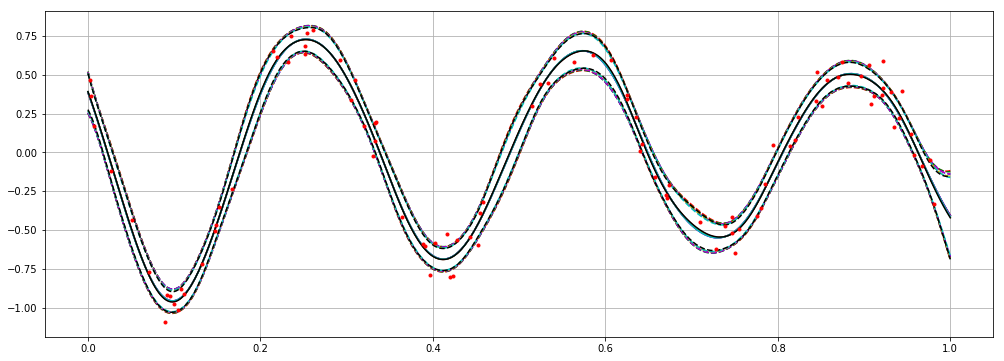

In [10]:
plt.figure(figsize=(17, 6))
for i, mod in enumerate(models):
    col = colors[i]
    mean_pred, cov_pred = mod.predict(X_pred)
    std_pred = np.sqrt(np.diag(cov_pred))
    plt.plot(X_pred.ravel(), mean_pred.ravel(), col + "-")
    plt.plot(X_pred.ravel(), mean_pred.ravel() + 2. * std_pred, col + "--")
    plt.plot(X_pred.ravel(), mean_pred.ravel() - 2. * std_pred, col + "--")
plt.plot(X.ravel(), y.ravel(), "r.")
plt.grid()
plt.legend(fontsize=12)
plt.show()

Visualize the sampled acquisition functions as well as the integrated acquisition function and its maximum.

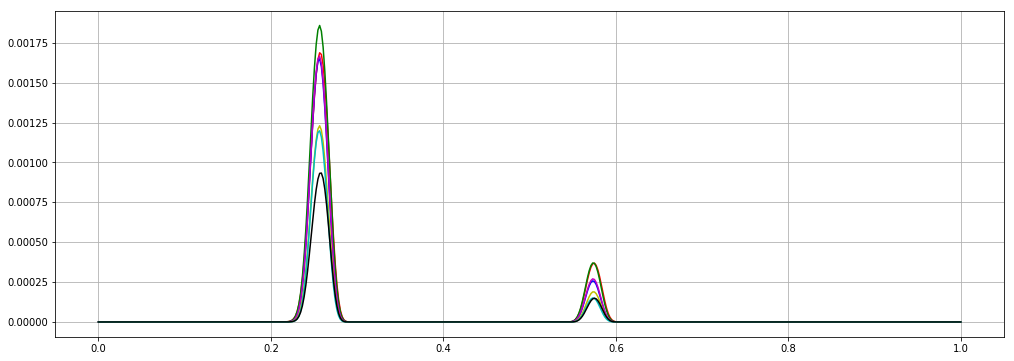

In [11]:
plt.figure(figsize=(17, 6))
for i in range(n_models):
    plt.plot(X_pred.ravel(), alpha[i], colors[i] + "-")
plt.grid()
plt.legend(fontsize=16)
plt.show()

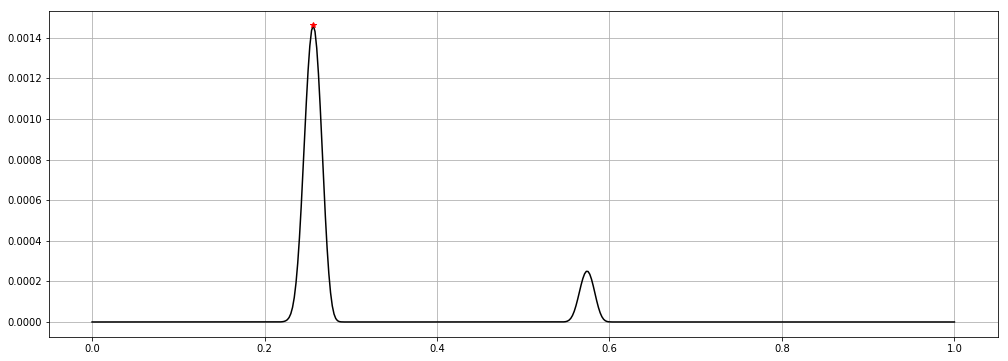

In [12]:
alpha_int = ei_acq.evaluate(X_pred)
ei_x, ei_max = ei_acq.select()
plt.figure(figsize=(17, 6))
plt.plot(X_pred.ravel(), alpha_int, "k-")
plt.plot(ei_x, ei_max, "r*")
plt.grid()
plt.legend(fontsize=16)
plt.show()